# Object Classification with kNN using SIFT features

In [1]:
import numpy as np
import os
import cv2
import cv2.xfeatures2d as features
import yaml
import matplotlib.pyplot as plt
from typing import List

from BoWModel import bag_of_words
from kNN import knn_classification

%load_ext autoreload
%autoreload 2

In [2]:
cv2.__version__

'4.5.3'

In [3]:
def imshow_for_jupyter_notebook(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)

## Load Dataset

Every 5th image in the images folder is assigned to be test data, making a total of 212 training images, 53 test images.

number of training data:  212
number of test data:  53


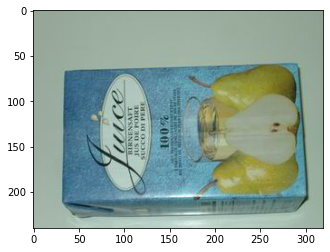

In [4]:
train_data = []
train_label = []
test_data = []
test_label = []
for i in range(265):
    filename = "images/" + str(i).zfill(3) + ".jpg"
    if i % 5 == 0:
        test_data.append(cv2.imread(filename))
        test_label.append(i//5)
    else:
        train_data.append(cv2.imread(filename))
        train_label.append(i//5)
    
print("number of training data: ", len(train_data))
print("number of test data: ", len(test_data))
imshow_for_jupyter_notebook(train_data[15])

## Extract SIFT Features

[ WARN:0] global /home/conda/feedstock_root/build_artifacts/libopencv_1633800893877/work/opencv_contrib/modules/xfeatures2d/misc/python/shadow_sift.hpp (13) SIFT_create DEPRECATED: cv.xfeatures2d.SIFT_create() is deprecated due SIFT tranfer to the main repository. https://github.com/opencv/opencv/issues/16736


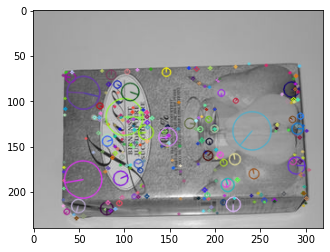

In [5]:
img = train_data[15]
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
sift = cv2.xfeatures2d.SIFT_create()
kp = sift.detect(gray, None)
img_sift = cv2.drawKeypoints(gray, kp, img, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
imshow_for_jupyter_notebook(img_sift)

## Build BoW Dictionary

A BoW dictionary of 54 words is generated by grouping the SIFT features using KMeans clustering.

In [6]:
dictionarySize = 54
bow_trainer = cv2.BOWKMeansTrainer(dictionarySize)
sift = cv2.xfeatures2d.SIFT_create()

kps=[]
for p in train_data:
    gray_img = cv2.cvtColor(p, cv2.COLOR_BGR2GRAY)
    kp, dsc = sift.detectAndCompute(gray_img, None)
    bow_trainer.add(dsc)
    kps.append(kp)

dictionary = bow_trainer.cluster()
c = cv2.FileStorage("vocabulary.yaml", cv2.FileStorage_WRITE)
c.write('dictionary', dictionary)
c.release()
print("dictionary.shape:", dictionary.shape)

dictionary.shape: (54, 128)


In [7]:
matcher = cv2.FlannBasedMatcher()
bow_extractor = cv2.BOWImgDescriptorExtractor(sift, matcher)
bow_extractor.setVocabulary( dictionary )

feature_bows = []
for img in train_data:
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    kp, dsc = sift.detectAndCompute(gray, None)
    feature_bow = bow_extractor.compute(img, kp)
    feature_bows.append(feature_bow.squeeze())

feature_bows = np.stack(feature_bows)
print("feature_bows.shape:", feature_bows.shape)

feature_bows.shape: (212, 54)


## Histogram of the BoW descriptor for one Image

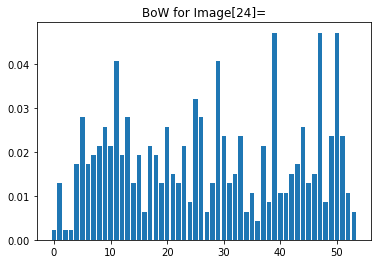

In [8]:
idx = 24
_ = plt.bar(range(54), feature_bows[idx])
_ = plt.title("BoW for Image[{}]=".format(str(idx)))

## Classify the test images with kNN Classifier

Classification is done using SIFT BoW Model and a k-Nearest-Neighbor classifier with Euclidean Distance metric

In [9]:
print("Testing with KNN=1")
stats = {"true": 0, "false": 0}
for img_num in range(len(test_data)):
    prediction = knn_classification(feature_bows, test_data, img_num, knn=1)
    
    if prediction == img_num:
        stats["true"] += 1
    else:
        stats["false"] += 1
        
print(stats)
print("Accuracy:", stats["true"] / len(test_data))

print("Testing with KNN=3")
stats = {"true": 0, "false": 0}
for img_num in range(len(test_data)):
    prediction = knn_classification(feature_bows, test_data, img_num, knn=3)
    
    if prediction == img_num:
        stats["true"] += 1
    else:
        stats["false"] += 1
        
print(stats)
print("Accuracy:", stats["true"] / len(test_data))

Testing with KNN=1
{'true': 39, 'false': 14}
Accuracy: 0.7358490566037735
Testing with KNN=3
{'true': 37, 'false': 16}
Accuracy: 0.6981132075471698
